In [1]:
import cv2
import numpy as np
import os
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy.linalg
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



def display_image(window_name, img, window_1_name=None, img_1=None):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if window_1_name is not None and img_1 is not None:
        plt.figure(figsize=(60, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title(window_name)
        plt.subplot(1, 2, 2)
        plt.imshow(img_1, cmap="gray")
        plt.title(window_1_name)
    else:
        plt.imshow(img)
        plt.title(window_name)
        plt.show()

def display_1_rgb(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()

def display_1_gray(name, img):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    plt.imshow(img, cmap="gray")
    plt.title(name)
    plt.show()

def display_1_img(name:str, img, mode:str="rgb"):
    """
    Displays image with given window name.
    :param window_name: name of the window
    :param img: image object to display
    """
    if mode == "gray":
        plt.imshow(img, cmap="gray")
    elif mode == "fire":
        plt.imshow(img, cmap="inferno")
    else:
        plt.imshow(img[:, :, ::-1])
    plt.title(name)
    plt.show()




def plot_points(ax, V, fill='lawngreen', alpha=1):
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.scatter(V[:,0], V[:,1], color=fill,
               linewidth=2, s=2, alpha=alpha)    
    return ax

def plot_points_lines(ax, V, fill='lawngreen', alpha=1):
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.scatter(V[:,0], V[:,1], color=fill,
               linewidth=2, s=2, alpha=alpha)
    ax.plot(V_plt[:,0], V_plt[:,1], color=fill,
            linewidth=2, alpha=alpha)
    
    return ax

def display_image_with_points(img, V, title="initial state"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121)
    ax.imshow(img[:, :, ::-1])
    ax.set_title(title)
    plot_points(ax, V)

def display_image_with_points_lines(img, V, title="initial state"):
    fig = plt.figure(figsize=(15, 7))
    ax = fig.add_subplot(121)
    ax.imshow(img[:, :, ::-1])
    ax.set_title(title)
    plot_points_lines(ax, V)

# Sheet 10

Given are two consecutive frames, you need to implement (10 points)
1. Extract SIFT key points and features.
2. Compute corresponding points of two frames.
3. Utilizing the given projection matrix to compute their 3D locations. (use DLT)
4. Visualizing the matches on two frames

In [2]:
# Load data
query_img = cv2.imread('data/1.jpg')
train_img = cv2.imread('data/2.jpg')

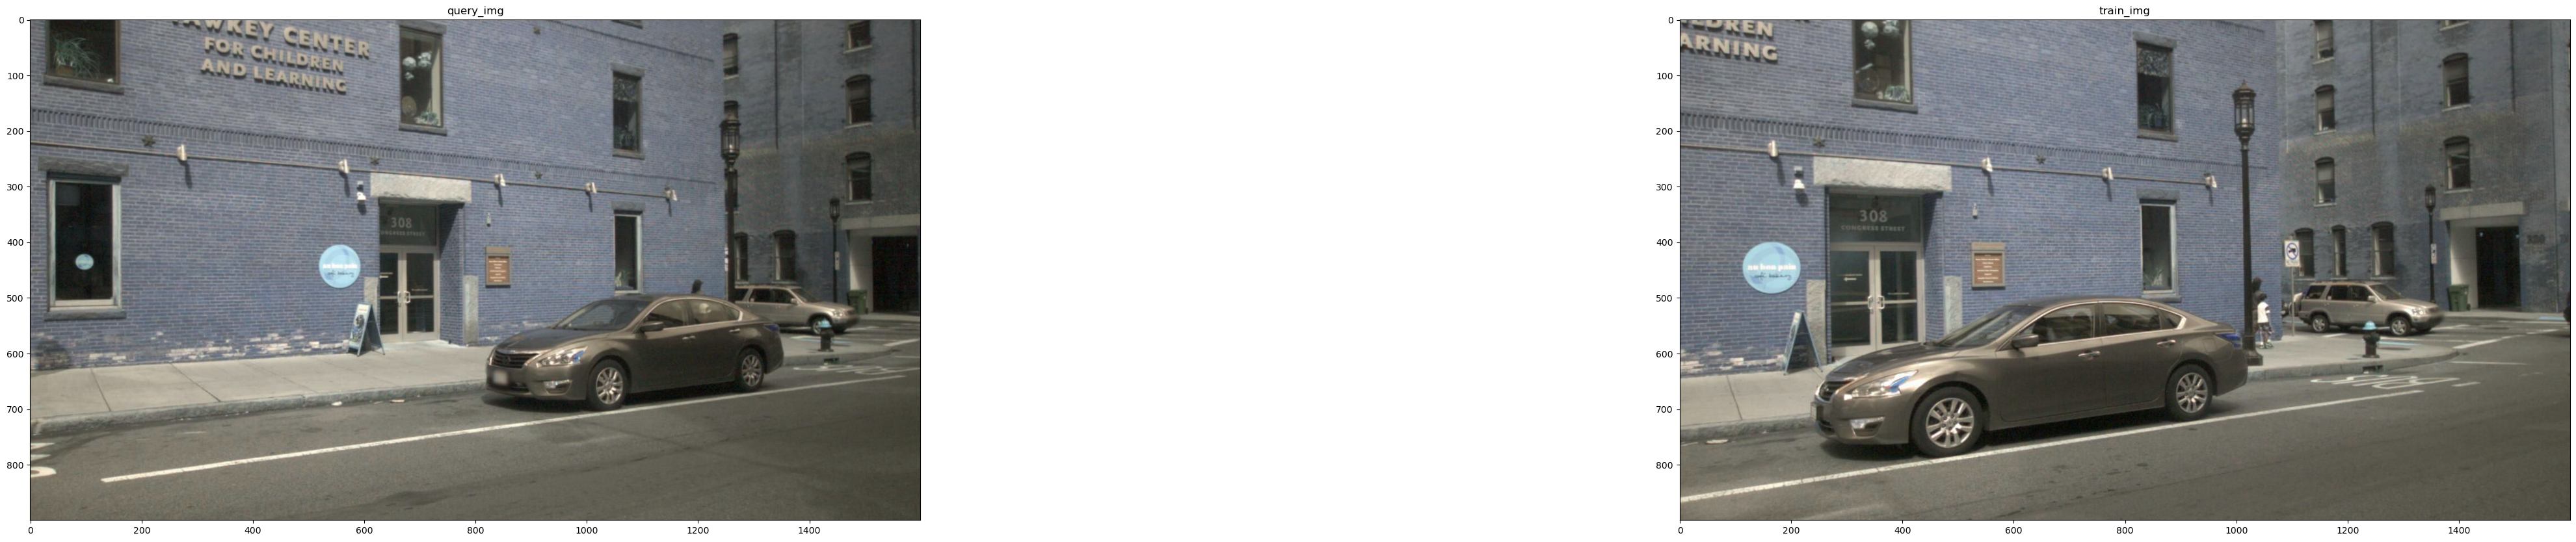

In [3]:
display_image("query_img", query_img, "train_img", train_img)

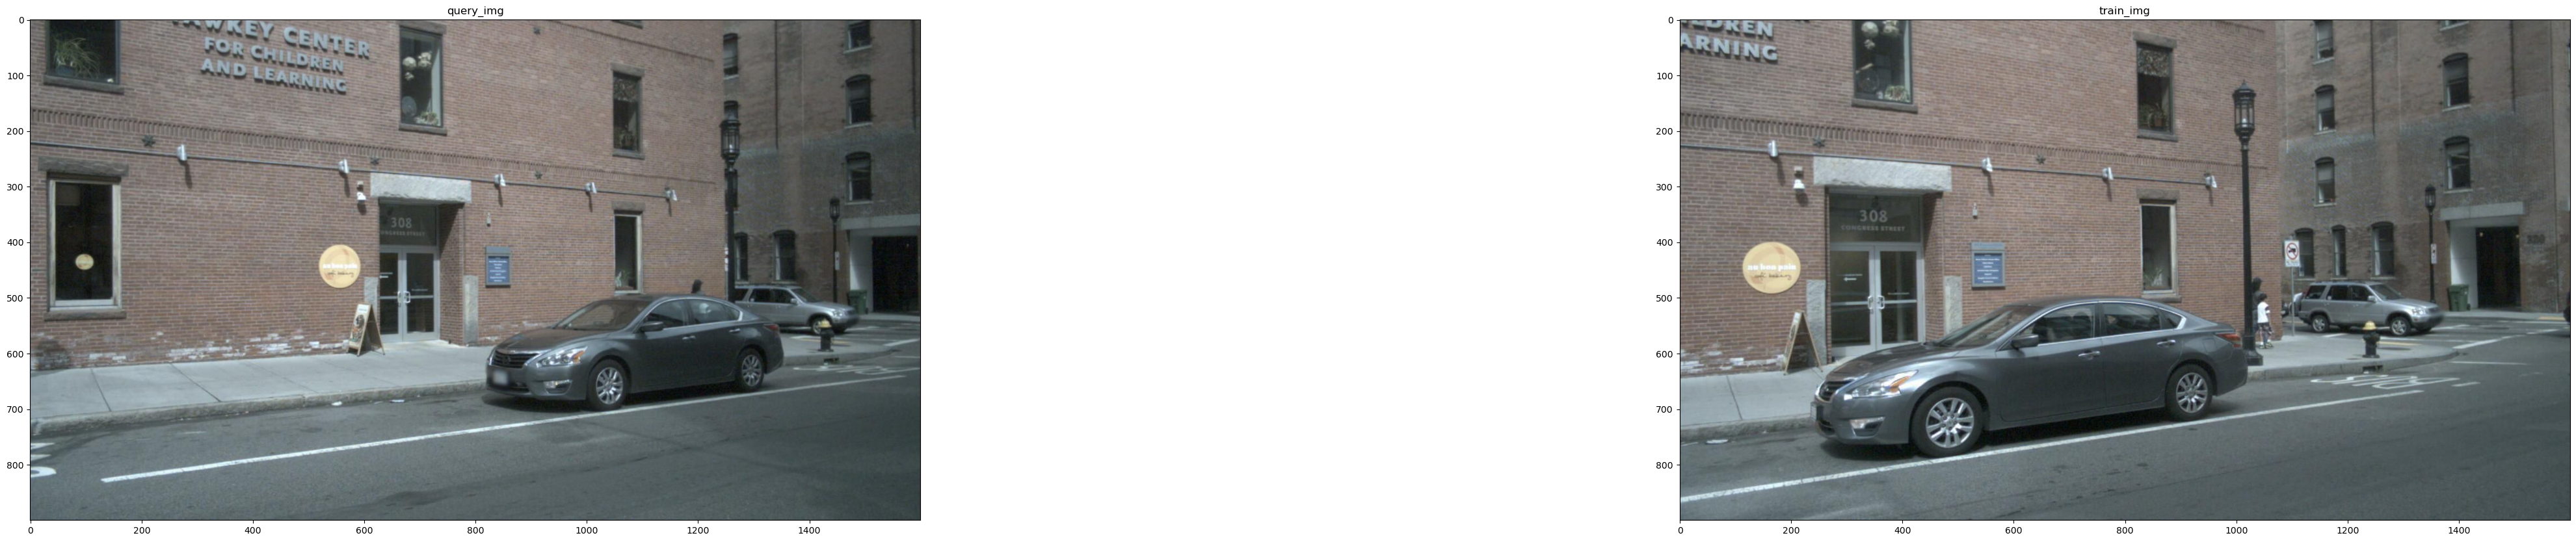

In [4]:
# set right channel order
query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

display_image("query_img", query_img, "train_img", train_img)

In [5]:
# code in this cell is generally taken from my sheet 8 solution

import sklearn.neighbors

def getDMatches(kp_1, kp_2, dest_1, dest_2, img1, img2, threshold=0.5, own_implement=True):
    if(own_implement):
        knn = sklearn.neighbors.NearestNeighbors(n_neighbors=2, algorithm="auto", metric='euclidean')
        # fit the model to the descriptors of the first image
        knn.fit(dest_1)
        # find the 2 nearest neighbours of the descriptors of the second image
        distances, indices = knn.kneighbors(dest_2)
        # calculate the ratio of the distances
        ratio = distances[:,0] / distances[:,1]
        # find the indices of the matches
        matches = np.argwhere(ratio < threshold)

        matches1to2 = []
        # iterate over the matches and append the corresponding keypoints to the list
        for match in matches:
            match = match[0]
            d_match = cv2.DMatch(indices[match,0], match, distances[match,0])
            matches1to2.append(d_match)

    else:
        # create a BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        # find the matches
        matches = bf.match(dest_1, dest_2)

        good = []
        for m in matches:
            if m.distance < threshold:
                good.append(m)
        # sort the matches based on the distance
        matches = sorted(matches, key=lambda x: x.distance)

        matches1to2 = matches

    return matches1to2

def matching(img1, img_2, threshold=0.5, own_implement=True, img_name=""):
    sift = cv2.SIFT_create()
    kp_1, des_1 = sift.detectAndCompute(img1, None)
    kp_2, des_2 = sift.detectAndCompute(img_2, None)
    
    matches1to2 = getDMatches(kp_1, kp_2, des_1, des_2, img1, img_2, threshold=threshold, own_implement=own_implement)
     
    result = cv2.drawMatches(img1, kp_1, img_2, kp_2, matches1to2, None)

    return result, matches1to2, (kp_1, des_1), (kp_2, des_2)

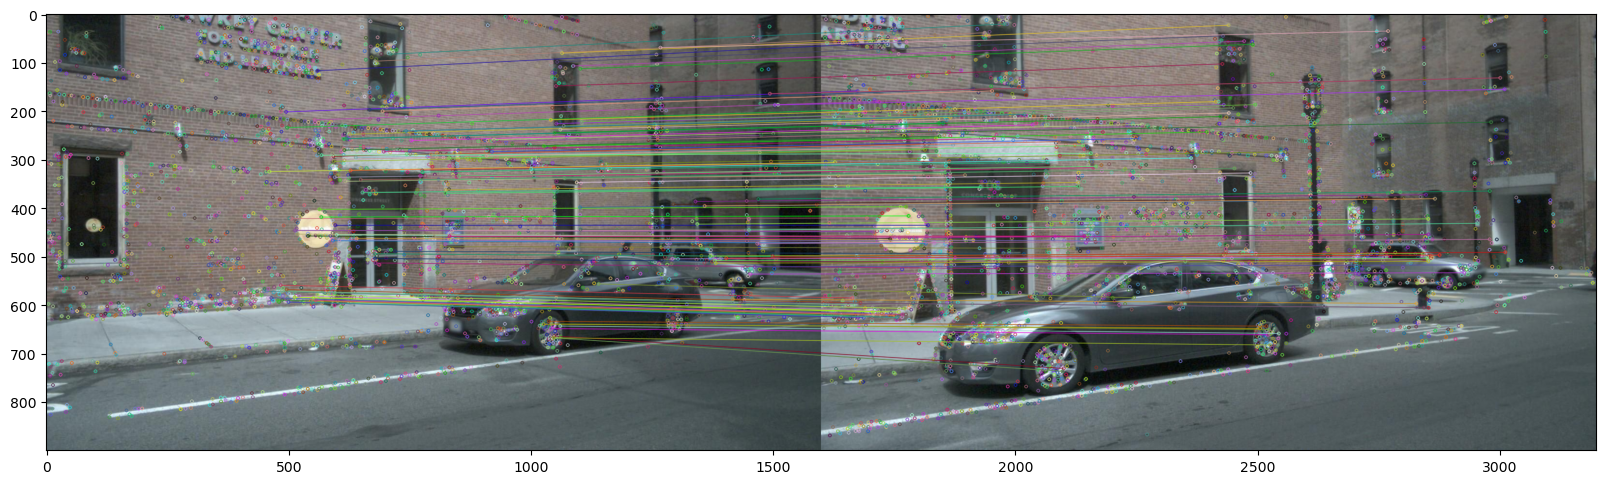

In [6]:
matches_img, matches1to2, (kp_1, des_1), (kp_2, des_2) = matching(query_img, train_img, threshold=0.5, own_implement=True, img_name="Own implementation of matching")

# plot the matches
plt.figure(figsize=(20, 7))
plt.imshow(matches_img)
plt.show()

In [7]:
# Projection matrixs for query_img and train_img
P_q = np.array([[1.0, 0, 0, 0],
                [0, 1.0, 0, 0],
                [0, 0, 1.0, 0]])

P_t = np.array([[1.0, 0, 0, 1],
                [0, 1.0, 0, 1],
                [0, 0, 1.0, 0]])

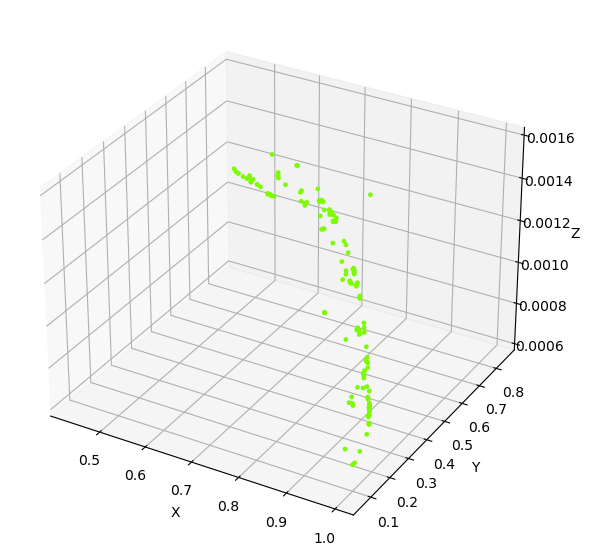

In [8]:
# Compute 3D points
points3D = cv2.triangulatePoints(P_q, P_t, np.array([kp_1[m.queryIdx].pt for m in matches1to2]).T, np.array([kp_2[m.trainIdx].pt for m in matches1to2]).T)

# Normalize the points
# points3D = points3D / points3D[-1]


# Plot the 3D points
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3D[0], points3D[1], points3D[2], color='lawngreen', linewidth=2, s=2, alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()



In [9]:
# here is the same code as above, but in interactive mode

%matplotlib
plt.ion()

# Plot the 3D points
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3D[0], points3D[1], points3D[2], color='lawngreen', linewidth=2, s=2, alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

try:
    while fig.number in plt.get_fignums():
        plt.pause(0.1)
except:
    plt.close(fig.number)
    raise


Using matplotlib backend: <object object at 0x000001CB4F0F89F0>
